<a href="https://colab.research.google.com/github/ClaudioAresu/FoodVision_Project/blob/main/Project_Food_Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Milestone Project 1: Food Vision Big

In [ ]:
# Check compute capability (7.0+) of GPU for mixed precision training.
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-1cc8cd38-54c9-447d-e4b5-37d131632d98)


In [ ]:
# Import helper functions
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-03-10 11:44:16--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-03-10 11:44:16 (90.9 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys as compare_histories

## Use TensorFlow datasets to download data

In [ ]:
# Get TensorFlow Datasets
import tensorflow_datasets as tfds

In [ ]:
# List all available datasets
datasets_list = tfds.list_builders() # get all available datasets in TFDS
print("food101" in datasets_list) # is our dataset in the list of TFDS datasets?

True


In [ ]:
# Load in the data (takes 5-6 minutes in Google Colab)
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train", "validation"],
                                             shuffle_files=True,
                                             as_supervised=True, # data gets returned in tuple format (data, label)
                                             with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteVTHJB5/food101-train.tfrecord*...:   0%|          …

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteVTHJB5/food101-validation.tfrecord*...:   0%|     …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [ ]:
# Features of Food101 from TFDS
ds_info.features


FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

## Exploring the Food101 data from Tensorflow Datasets

In [ ]:
# Get the class names
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [ ]:
 # Take one sample of the train data
train_one_sample = train_data.take(1) # samples are in format (image_tensor, label)
train_one_sample

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
# Output info about our training sample
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape},
  Image datatype: {image.dtype},
  Target class from Food101 (tensor form): {label},
  Class name (str form): {class_names[label.numpy()]},
  """)


  Image shape: (512, 512, 3),
  Image datatype: <dtype: 'uint8'>,
  Target class from Food101 (tensor form): 23,
  Class name (str form): churros,
  


In [ ]:
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[ 93,  34,  40],
        [ 93,  34,  40],
        [ 94,  35,  41],
        ...,
        [ 52,  15,  23],
        [ 52,  15,  23],
        [ 52,  15,  23]],

       [[ 93,  34,  40],
        [ 93,  34,  40],
        [ 94,  35,  41],
        ...,
        [ 52,  15,  23],
        [ 52,  15,  23],
        [ 52,  15,  23]],

       [[ 93,  34,  40],
        [ 93,  34,  40],
        [ 94,  35,  41],
        ...,
        [ 54,  14,  23],
        [ 52,  15,  23],
        [ 52,  15,  23]],

       ...,

       [[108,  31,  49],
        [106,  29,  47],
        [105,  28,  46],
        ...,
        [121,  38,  56],
        [122,  39,  59],
        [123,  40,  60]],

       [[107,  30,  48],
        [107,  30,  48],
        [107,  30,  48],
        ...,
        [121,  38,  58],
        [123,  40,  60],
        [123,  40,  60]],

       [[106,  29,  47],
        [108,  31,  49],
        [109,  32,  50],
        ...,
        [123,  40,  6

In [ ]:
# What are the min and max values of our image tensor?
import tensorflow as tf
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=9>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

### Plot an image from TensorFlow Dataset

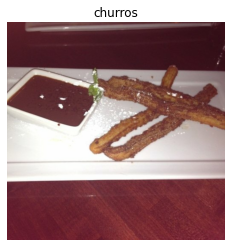

In [ ]:
# Plot an image tensor
import matplotlib.pyplot as plt

plt.imshow(image)
plt.title(class_names[label.numpy()]) # Add title to image to verify if the label is associated with the corresponding image
plt.axis(False);

## Create preprocessing functions

In [ ]:
def preprocess_img(image, label, img_shape=224):
  """
  Converts image datatype from 'uint8' -> 'float32' and reshapes
  image to [img_shape, img_shape, colour_channels]
  """
  image = tf.image.resize(image, [img_shape, img_shape]) # reshape the image
  return tf.cast(image, tf.float32), label # return (float32_image, label) tuple

In [ ]:
# Preprocess a single sample image and check the outputs
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}...,\nShape {image.shape}, \nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n{preprocessed_img[:2]}...,\nShape:{preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype}")

Image before preprocessing:
 [[[93 34 40]
  [93 34 40]
  [94 35 41]
  ...
  [52 15 23]
  [52 15 23]
  [52 15 23]]

 [[93 34 40]
  [93 34 40]
  [94 35 41]
  ...
  [52 15 23]
  [52 15 23]
  [52 15 23]]]...,
Shape (512, 512, 3), 
Datatype: <dtype: 'uint8'>

Image after preprocessing:
[[[93.       34.       40.      ]
  [94.       35.       41.      ]
  [95.       36.       42.      ]
  ...
  [55.       15.       24.      ]
  [52.       15.       23.      ]
  [52.       15.       23.      ]]

 [[93.92857  34.928574 40.928574]
  [93.07143  34.071426 40.071426]
  [94.       35.       41.      ]
  ...
  [55.       15.       24.      ]
  [54.       14.       23.      ]
  [52.       15.       23.      ]]]...,
Shape:(224, 224, 3),
Datatype: <dtype: 'float32'>


## Batch & prepare datasets

In [ ]:
# Map preprocessing function to training data (and parallelize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1024).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)
# Map preprocesing funciton to test data
test_data = test_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_data, test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

 ## Create modelling callbacks

In [ ]:
# Create tensorboard callback (import from helper_fucntions.py)
from helper_functions import create_tensorboard_callback
# Create ModelCheckpoint callback to save a model's progress during training
checkpoint_path = "model_checkpoints/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_acc",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=0)

## Setup mixed precision training

In [ ]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16") # set global datga policy to mixed precision


In [ ]:
mixed_precision.global_policy()

<Policy "mixed_float16">

 ## Build feature extraction model

In [ ]:
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create functional model
inputs = layers.Input(shape=input_shape, name="input_layer")
x = base_model(inputs, training=False) # make sure layers which should be in inference only stay like that
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax", dtype="float32", name="softmax_float32")(x)
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

16705208/16705208 [==============================] - 1s 0us/step


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [ ]:
# Check layer dtype policies
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
global_average_pooling2d True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


Going through the above we see:
* `layer.name`: the human readable name of a particular layer;
*`layer.trainable`: is the layer trainable or not (if `False`, the weights are frozen);
*`layer.dtype`: the datatype a layer stores its variables in;
*`layer.dtype_policy`: the data type policy a layer computes on its variable with.

In [ ]:
for layer in model.layers[1].layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 False float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "mixed_float16">
rescaling_1 False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <

In [ ]:
# Fit the feature extraction model data
history_101_classes_feature = model.fit(train_data,
                                        epochs=3,
                                        steps_per_epoch=len(train_data),
                                        validation_data=test_data,
                                        validation_steps=int(0.15 * len(test_data)),
                                        callbacks=[create_tensorboard_callback(dir_name="training_logs",
                                                                              experiment_name="efficientnetb0_101_classes_all_data_feature_extract" ),
                                                    model_checkpoint],
                                        verbose=2)

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_feature_extract/20230310-115457


Epoch 1/3


2368/2368 - 180s - loss: 1.7169 - accuracy: 0.5832 - val_loss: 1.1330 - val_accuracy: 0.7026 - 180s/epoch - 76ms/step
Epoch 2/3


2368/2368 - 173s - loss: 1.2011 - accuracy: 0.6886 - val_loss: 1.0285 - val_accuracy: 0.7209 - 173s/epoch - 73ms/step
Epoch 3/3


2368/2368 - 167s - loss: 1.0547 - accuracy: 0.7239 - val_loss: 0.9867 - val_accuracy: 0.7248 - 167s/epoch - 70ms/step


In [ ]:
# Evaluate model on whole test dataset
results_feature_extract_model = model.evaluate(test_data)
results_feature_extract_model

790/790 [==============================] - 54s 68ms/step - loss: 0.9975 - accuracy: 0.7293


[0.9974506497383118, 0.7292672991752625]

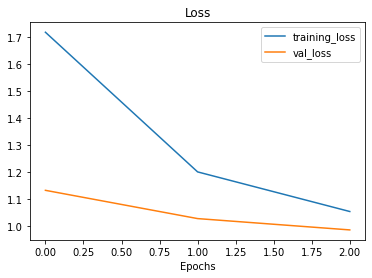

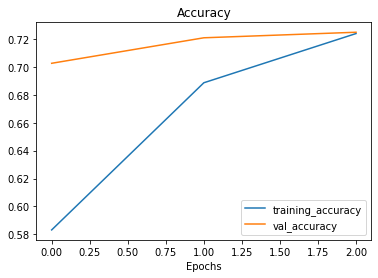

In [ ]:
plot_loss_curves(history_101_classes_feature)

## Savin, loading, and verifying the loaded model

In [ ]:
model.save("base_model")

TypeError: ignored

In [ ]:
loaded_model = tf.keras.models.load_model("base_model")

In [ ]:
# Evaluate loaded model and compare performance to pre-saved model
loaded_model_results = loaded_model.evaluate(test_data)
loaded_model_results

In [ ]:
results_downloaded_model = loaded_model.evaluate(test_data)
results_downloaded_model

In [ ]:
import numpy as np
np.isclose(results_feature_extract_model, results_downloaded_model)

##Generate predictions

In [ ]:
preds_probs = model.predict(test_data, verbose=1)

len(preds_probs), preds_probs.shape, preds_probs[:10]

790/790 [==============================] - 54s 66ms/step


(25250,
 (25250, 101),
 array([[4.2981934e-08, 2.5519546e-07, 6.0278112e-06, ..., 2.0866054e-08,
         5.6278413e-08, 1.6571011e-08],
        [3.2830911e-08, 5.8307955e-07, 2.1035409e-07, ..., 1.1545541e-09,
         2.4003330e-06, 1.9150100e-08],
        [1.2807629e-02, 2.5166749e-04, 5.7382678e-04, ..., 1.4117267e-04,
         4.8321061e-04, 1.0931939e-03],
        ...,
        [2.2626423e-06, 1.0378399e-05, 2.1090145e-06, ..., 1.5450089e-05,
         4.8322991e-06, 1.5536141e-05],
        [4.0998696e-03, 1.9430604e-07, 2.4351284e-06, ..., 2.9570325e-07,
         8.3689112e-05, 1.6164568e-05],
        [4.1659479e-03, 1.5460117e-05, 1.1950220e-03, ..., 2.0006877e-05,
         1.3508353e-03, 3.4976270e-05]], dtype=float32))

In [ ]:
# Get the pred classes of each label
pred_classes = preds_probs.argmax(axis=1)

len(pred_classes), pred_classes[:10]

(25250, array([65, 70, 34,  1, 81, 61, 55, 54, 76, 82]))

In [ ]:
# To get our test labels we need to unravel our tes_data BatchDataset
y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax()) # we want the index value where the value 1 is
y_labels[:10] # look at the first 10

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
#let's try scikit-learn's accuracy metric score function and see what it comes up with
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_true=y_labels,
                                  y_pred=pred_classes)

sklearn_accuracy, len(y_labels), len(test_data), #results_downloaded_model

(0.013069306930693069, 25250, 790)

## Add an augmentation layer to our model

In [ ]:
from tensorflow.keras.models import Sequential
data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2)
], name="data_augmentation")

In [ ]:
# Add the data augmentation layer to our model
inputs = layers.Input(shape=input_shape, name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training=False) # make sure layers which should be in inference only stay like that
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax", dtype="float32", name="softmax_float32")(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
# Recompile the model after data augmentation (without changing any variable)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [ ]:
# Refit the model
history_101_classes_data_augmentation = model.fit(train_data,
                                                  epochs=3,
                                                  steps_per_epoch=len(train_data),
                                                  validation_data=test_data,
                                                  validation_steps=int(0.15 * len(test_data)),
                                                  callbacks=[create_tensorboard_callback(dir_name="training_logs",
                                                                                         experiment_name="efficientnetb0_101_classes_all_data_data_augmentation"),
                                                             model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_data_augmentation/20230310-120921
Epoch 1/3


2368/2368 [==============================] - ETA: 0s - loss: 2.1010 - accuracy: 0.4930

2368/2368 [==============================] - 583s 241ms/step - loss: 2.1010 - accuracy: 0.4930 - val_loss: 1.2719 - val_accuracy: 0.6597
Epoch 2/3
2368/2368 [==============================] - ETA: 0s - loss: 1.6114 - accuracy: 0.5903

2368/2368 [==============================] - 536s 226ms/step - loss: 1.6114 - accuracy: 0.5903 - val_loss: 1.1650 - val_accuracy: 0.6833
Epoch 3/3
2368/2368 [==============================] - ETA: 0s - loss: 1.4988 - accuracy: 0.6142

2368/2368 [==============================] - 522s 220ms/step - loss: 1.4988 - accuracy: 0.6142 - val_loss: 1.1269 - val_accuracy: 0.6909


In [ ]:
# Evaluate the test data after data augmentation
results_data_augmentation = model.evaluate(test_data)
results_data_augmentation

790/790 [==============================] - 52s 65ms/step - loss: 1.1486 - accuracy: 0.6863


[1.1486306190490723, 0.6862970590591431]

In [ ]:
# Plot to check the loss and accuracy curves
plot_loss_curves(history_101_classes_data_augmentation)

## Fine-tuning the data

In [ ]:
#Setting up EarlyStopping callback

early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, start_from_epoch=history_101_classes_data_augmentation.epoch[-1])

In [ ]:
# Unfreeze layers in base model
base_model.trainable = True

# Refreeze every layer except the last 10
for layer in base_model.layers[:-10]:
  layer.trainable = False

In [ ]:
# Check which layers are trainable in our base model
for layer_number, layer in enumerate(model.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze False
39

In [ ]:
# Recompile the model
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(0.0001),
              metrics=["accuracy"])

In [ ]:
# Set up fine tune epochs global variable
fine_tune_epochs = 7 # Model had already done 3, we'll try for another 4

# Fine-tune the model
history_101_classes_fine_tune = model.fit(train_data,
                                          steps_per_epoch=len(train_data),
                                          epochs=fine_tune_epochs,
                                          validation_data=test_data,
                                          validation_steps=int(0.15 * len(test_data)),
                                          initial_epoch=history_101_classes_data_augmentation.epoch[-1],
                                          callbacks=[create_tensorboard_callback(dir_name="training_logs",
                                                                              experiment_name="efficientnetb0_101_classes_all_data_fine_tune"),
                                                     model_checkpoint,
                                                     early_stopping])

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_fine_tune/20230310-123806
Epoch 3/7


2368/2368 [==============================] - ETA: 0s - loss: 1.3136 - accuracy: 0.6570

2368/2368 [==============================] - 547s 224ms/step - loss: 1.3136 - accuracy: 0.6570 - val_loss: 1.0241 - val_accuracy: 0.7129
Epoch 4/7
2368/2368 [==============================] - ETA: 0s - loss: 1.1972 - accuracy: 0.6851

2368/2368 [==============================] - 521s 219ms/step - loss: 1.1972 - accuracy: 0.6851 - val_loss: 1.0176 - val_accuracy: 0.7145
Epoch 5/7
2368/2368 [==============================] - ETA: 0s - loss: 1.1142 - accuracy: 0.7019

2368/2368 [==============================] - 529s 222ms/step - loss: 1.1142 - accuracy: 0.7019 - val_loss: 0.9715 - val_accuracy: 0.7278
Epoch 6/7
2368/2368 [==============================] - ETA: 0s - loss: 1.0521 - accuracy: 0.7177

2368/2368 [==============================] - 521s 219ms/step - loss: 1.0521 - accuracy: 0.7177 - val_loss: 0.9667 - val_accuracy: 0.7325
Epoch 7/7
2368/2368 [==============================] - ETA: 0s - loss: 1.0024 - accuracy: 0.7290

2368/2368 [==============================] - 523s 220ms/step - loss: 1.0024 - accuracy: 0.7290 - val_loss: 0.9512 - val_accuracy: 0.7354


In [ ]:
# Compare the fine-tuned model to the base model
from helper_functions import compare_historys as compare_histories

compare_histories(original_history=history_101_classes_data_augmentation,
                  new_history=history_101_classes_fine_tune,
                  initial_epochs=3) 

NameError: ignored

In [ ]:
# Evaluate the fine-tuned test data
results_fine_tune = model.evaluate(test_data)
results_fine_tune

In [ ]:
# Unfreeze all the layers in base model
base_model.trainable = True

# Check which layers are trainable in our base model
for layer_number, layer in enumerate(model.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

In [ ]:
# Recompile the model
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(0.0001),
              metrics=["accuracy"])

In [ ]:
# Set up fine tune epochs global variable
fine_tune_epochs_final = 100 # Model had already done 3, we'll try for another 4

# Fine-tune the model
history_101_classes_fine_tune_final = model.fit(train_data,
                                          steps_per_epoch=len(train_data),
                                          epochs=fine_tune_epochs_final,
                                          validation_data=test_data,
                                          validation_steps=int(0.15 * len(test_data)),
                                          initial_epoch=history_101_classes_fine_tune.epoch[-1],
                                          callbacks=[create_tensorboard_callback(dir_name="training_logs",
                                                                              experiment_name="efficientnetb0_101_classes_all_data_fine_tune"),
                                                     model_checkpoint,
                                                     early_stopping])

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_fine_tune/20230310-132430
Epoch 7/7


In [ ]:
# Evalaute on the whole test data
food_vision_fine_tune_results = model.evaluate(test_data)
food_vision_fine_tune_results

In [ ]:
# Plot loss and accuracy curves
plot_loss_curves(history_101_classes_fine_tune_final)

##Evaluation with confusion matrix

In [ ]:
preds_probs = model.predict(test_data, verbose=1)

len(preds_probs), preds_probs.shape, preds_probs[:10]

790/790 [==============================] - 54s 66ms/step


(25250,
 (25250, 101),
 array([[4.2981934e-08, 2.5519546e-07, 6.0278112e-06, ..., 2.0866054e-08,
         5.6278413e-08, 1.6571011e-08],
        [3.2830911e-08, 5.8307955e-07, 2.1035409e-07, ..., 1.1545541e-09,
         2.4003330e-06, 1.9150100e-08],
        [1.2807629e-02, 2.5166749e-04, 5.7382678e-04, ..., 1.4117267e-04,
         4.8321061e-04, 1.0931939e-03],
        ...,
        [2.2626423e-06, 1.0378399e-05, 2.1090145e-06, ..., 1.5450089e-05,
         4.8322991e-06, 1.5536141e-05],
        [4.0998696e-03, 1.9430604e-07, 2.4351284e-06, ..., 2.9570325e-07,
         8.3689112e-05, 1.6164568e-05],
        [4.1659479e-03, 1.5460117e-05, 1.1950220e-03, ..., 2.0006877e-05,
         1.3508353e-03, 3.4976270e-05]], dtype=float32))

In [ ]:
# Get the pred classes of each label
pred_classes = preds_probs.argmax(axis=1)

len(pred_classes), pred_classes[:10]

(25250, array([65, 70, 34,  1, 81, 61, 55, 54, 76, 82]))

In [ ]:
# To get our test labels we need to unravel our tes_data BatchDataset
y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax()) # we want the index value where the value 1 is
y_labels[:10] # look at the first 10

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
#let's try scikit-learn's accuracy metric score function and see what it comes up with
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_true=y_labels,
                                  y_pred=pred_classes)

sklearn_accuracy, len(y_labels), len(test_data), #results_downloaded_model

(0.013069306930693069, 25250, 790)

In [ ]:
# define a confusion matrix to better visualize which classes have the hardest time 
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix


def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Changed (plot x-labels vertically) ###
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")


In [ ]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=20,
                      savefig=True)

##Evaluation with F-1 score

In [ ]:
# Get a dictionary of the classification report
from sklearn.metrics import classification_report
print(classification_report(y_true=y_labels,
                            y_pred=pred_classes))

classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

In [ ]:
# Create empty dictionary
class_f1_score = {}
# Loop through classification report dictionary items
for k, v in classification_report_dict.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
    # Add class names and f1-scores to new dictionary
    class_f1_score[class_names[int(k)]] = v["f1-score"]
class_f1_score

In [ ]:
# One simple way to order is using sorted function of python
import operator
print('Original dictionary : ', class_f1_score)
sorted_class_f1_score = sorted(class_f1_score.items(), key=operator.itemgetter(1))
print('Dictionary in ascending order by value : ',sorted_class_f1_score)

In [ ]:
 But our motto is "Visualize, visualize, visualize", so a better way to visualize the data is to turn f1-scores into dataframe for visualization
import pandas as pd
f1_scores = pd.DataFrame({"class_names": list(class_f1_score.keys()),
                          "f1-score": list(class_f1_score.values())}).sort_values("f1-score", ascending=False)

In [ ]:
fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values) # get f1-score values
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores["class_names"])
ax.set_xlabel("F1-score")
ax.set_title("F1-scores for 101 different food calsses (predicted by Food Vision mini")
ax.invert_yaxis(); #reverse the order of our model

##Visualizing predictions on custom images

In [ ]:
def load_and_prep_image(filename, img_shape=224, scale=True) :
  """
  Reads in an image from filename, turns it into a tensor and reshapes into specified shape (img_shape, img_shape, color_channels=3).
  specified shape (img_shape, img_shape, color_channels=3).

  Args:
    filename (str): path to target image
    image_shape (int): height/width dimension of target image size
    scale (bool): scale pixel values from 0-255 to 0-1 or not

  Returns:
    Image tensor of shape (img_shape, img_shape, 3)
  """
  # Read in the image
  img = tf.io.read_file(filename)

  # Decode image into tensor
  img = tf.io.decode_image(img, channels=3)

  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])

  # Scale? Yes/No
  if scale:
    # rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img # don't need to rescale iamges for EfficientNet models in TensorFlow

In [ ]:
# Make preds on a series of random images
import os
import random

plt.figure(figsize=(17, 10))
for i in range(3):
  # Choose random image(s) from a random class(es)
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + class_name))
  filepath = test_dir + class_name + "/" + filename
  print(filepath)

  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False)
  print(img.shape)
  img_expanded = tf.expand_dims(img, axis=0)
  print(img_expanded.shape)
  pred_prob = model.predict(img_expanded) # get prediction probability array
  pred_class = class_names[pred_prob.argmax()] #get highest prediction probability index
  print(pred_prob)
  print(pred_class)

  # Plot the image(s)
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class: # # if predicted class matches truth class, make
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color) 
  plt.axis(False);